In [314]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter

import string

import math
from itertools import cycle
import tqdm

Dataset downloaded from https://www.kaggle.com/c/ciphertext-challenge-iii/data

In [315]:
DIR_PATH = 'dataset/notracking/cypher/'

train_df = pd.read_csv(DIR_PATH + 'train.csv')
test_df = pd.read_csv(DIR_PATH + 'test.csv')
sub1 = pd.DataFrame({"ciphertext_id": test_df['ciphertext_id'],
                    "index" : 0})
sub2 = pd.DataFrame({"ciphertext_id": test_df['ciphertext_id'],
                    "index" : 0})


In [316]:
train_df['length'] = train_df.text.apply(len)
test_df['length'] = test_df.ciphertext.apply(len)

Extract Datasets for all 4 difficulty levels from test_df

In [317]:
df_level_1 = test_df[test_df.difficulty == 1]
df_level_2 = test_df[test_df.difficulty == 2]
df_level_3 = test_df[test_df.difficulty == 3]
df_level_4 = test_df[test_df.difficulty == 4]

In [318]:
plain_char_counter = Counter(''.join(train_df['text'].values))
plain_char_stats = pd.DataFrame([[item[0], item[1]] for item in plain_char_counter.items()], columns = ['Letter', 'Frequency']).sort_values(by='Frequency', ascending=False)

cypher_char_counter = Counter(''.join(df_level_1['ciphertext'].values))
cypher_char_stats = pd.DataFrame([[item[0], item[1]] for item in cypher_char_counter.items()], columns = ['Letter', 'Frequency']).sort_values(by='Frequency', ascending=False)

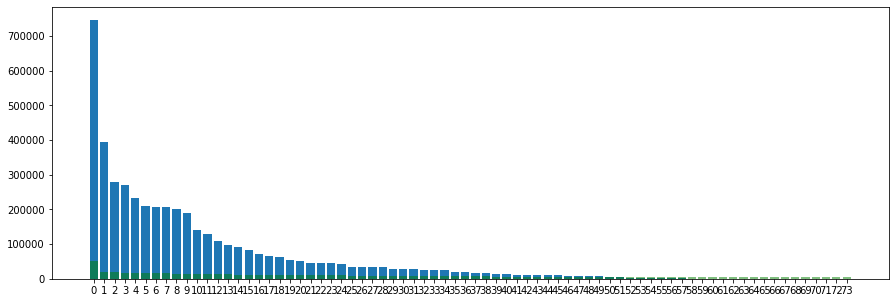

In [319]:
_, _ = plt.subplots(figsize=(15,5))
plt.bar(x = np.array(range(plain_char_stats.shape[0])), height = plain_char_stats['Frequency'].values)
plt.bar(x = np.array(range(cypher_char_stats.shape[0])), height = cypher_char_stats['Frequency'].values//4, alpha=.5,color='green')
plt.xticks(ticks = np.array(range(plain_char_stats.shape[0])), label = plain_char_stats['Letter'].values)
plt.show()

In [320]:
print(df_level_1.length.sort_values(ascending=False))
#df_level_1.length.describe([.999, .9999])
match = train_df[(400 < train_df.length) & (train_df.length <= 500)].text
print('Unciphered text:\n', train_df.loc[13862].text, '\n\nCiphered text (level 1):\n', df_level_1.loc[45272].ciphertext)
print('Unciphered text:\n', train_df.loc[6938].text, '\n\nCiphered text (level 1):\n', df_level_1.loc[95019].ciphertext)

45272    500
95019    400
91852    300
94408    300
35086    300
        ... 
72765    100
72768    100
72769    100
72770    100
0        100
Name: length, Length: 27158, dtype: int64
Unciphered text:
 Porter: Enter trumpets, sounding, then two Aldermen, Lord  Mayor, Garter, CRANMER, NORFOLK with his marshal's  staff, SUFFOLK, two Noblemen bearing great  standing-bowls for the christening-gifts, then  four Noblemen bearing a canopy, under which the  Duchess of Norfolk, godmother, bearing the child  richly habited in a mantle,  and c., train borne by a  Lady, then follows the Marchioness Dorset, the  other godmother, and Ladies. The troop pass once about the stage, and Garter speaks 

Ciphered text (level 1):
 gQUXDoBshspv: Tmfih sdycopxi, raydctrv, ssid sis Pkoihlpr, Bndh  Cyksh, Flvjdd, GHYYQTQ, YSHEAPA vtxw gtw cydwwyw'w  islju, RGJUNWO, jva Reawicdy ftydmdf rvtyf  wjyyhxmr-fevww und xwd nlhhextmtrv-ftjjr, fltm  qskq Ysqkpqtm mipqtrv y nednbd, kmoih vsmrg flt  Cggwdew ee Ysheapa, fa

There's only one Difficulty Level 1 text with length 500, on index 45272.

We could see that the cypher text preserves special characters like comma, space, dot, hypen. Also, and is encoded in different ways so it's not a simple text replacement cypher.


In [321]:
def decrypt_level_1(ciphertext):
    KEY = 'pyle'
    KEYLEN = len(KEY)
    
    key = [ord(t) - ord('a') for t in KEY]
    
    key_index = 0
    plaintext = ''
    
    for char in ciphertext:
        char_position = -1
        
        if string.ascii_lowercase[:-1].find(char) is not -1 :
            char_position = string.ascii_lowercase[:-1].find(char)
            char_set = string.ascii_lowercase[:-1]
        elif string.ascii_uppercase[:-1].find(char) is not -1:
            char_position = string.ascii_uppercase[:-1].find(char)
            char_set = string.ascii_uppercase[:-1]
        
        if char_position is not -1:
            p = (char_position - key[key_index]) % 25
            pc = char_set[p]
            
            key_index = (key_index + 1) % KEYLEN
        else:
            pc = char
            
        plaintext += pc 
        
    return plaintext

def encrypt_level_1(ptext, key_index=0):
    KEY = 'pyle'
    KEYLEN = len(KEY)
    key = [ord(c) - ord('a') for c in 'pyle']
    
    ctext = ''
    
    for c in ptext:
        pos = 'abcdefghijklmnopqrstuvwxy'.find(c)
        if pos != -1:
            p = (pos + key[key_index]) % 25
            cc = 'abcdefghijklmnopqrstuvwxy'[p]
            key_index = (key_index + 1) % KEYLEN
        else:
            pos = 'ABCDEFGHIJKLMNOPQRSTUVWXY'.find(c)
            if pos != -1:
                p = (pos + key[key_index]) % 25
                cc = 'ABCDEFGHIJKLMNOPQRSTUVWXY'[p]
                key_index = (key_index + 1) % KEYLEN
            else:
                cc = c
        ctext += cc
    return ctext

In [322]:
plain_dict = {}
for p_id, row in train_df.iterrows():
    text = row['text']
    plain_dict[text] = p_id
print(len(plain_dict))

108755


In [323]:
matched, unmatched = 0, 0
for c_id, row in df_level_1.iterrows():
    decrypted = decrypt_level_1(row['ciphertext'])
    found = False
    for pad in range(100):
        start = pad // 2
        end = len(decrypted) - (pad + 1) // 2
        plain_pie = decrypted[start:end]
        if plain_pie in plain_dict:
            p_id = plain_dict[plain_pie]
            row = train_df.loc[p_id]
            sub1.loc[c_id, 'index'] = train_df.loc[p_id]['index']
            matched += 1
            found = True
            break
    if not found:
        unmatched += 1
        print(decrypted)

print(f"Matched {matched}   Unmatched {unmatched}")
sub1.to_csv(DIR_PATH + 'submit-level-1.csv')

Matched 27158   Unmatched 0


In [324]:
def rail_pattern(n):
    r = list(range(n))
    return cycle(r + r[-2:0:-1])

def encrypt_level_2(plaintext, rails=21):
    p = rail_pattern(rails)
    # this relies on key being called in order, guaranteed?
    return ''.join(sorted(plaintext, key=lambda i: next(p)))
def decrypt_level_2(ciphertext, rails=21):
    p = rail_pattern(rails)
    indexes = sorted(range(len(ciphertext)), key=lambda i: next(p))
    result = [''] * len(ciphertext)
    for i, c in zip(indexes, ciphertext):
        result[i] = c
    return ''.join(result)

In [325]:
print(sub2.loc[87221])

ciphertext_id    ID_aa875b34b
index                       0
Name: 87221, dtype: object


In [326]:
matched, unmatched = 0, 0
for c_id, row in tqdm.tqdm(df_level_2.iterrows()):
    decrypted = decrypt_level_1(decrypt_level_2(row['ciphertext']))
    found = False
    for pad in range(100):
        start = pad // 2
        end = len(decrypted) - (pad + 1) // 2
        plain_pie = decrypted[start:end]
        if plain_pie in plain_dict:
            p_id = plain_dict[plain_pie]
            
            sub2.loc[c_id, 'index'] = train_df.loc[p_id]['index']
            matched += 1
            found = True
            break
    if not found:
        unmatched += 1
        print(decrypted)
            
print(f"Matched {matched}   Unmatched {unmatched}")
sub2.to_csv(DIR_PATH + 'submit-level-2.csv', index = False)

26849it [00:20, 1303.14it/s]


Matched 26849   Unmatched 0
